# Mạth - Assignment 5,6

### 5. Implement Linear Regression, Logistic Regression, and SoftMax Regression in the following fashions:
- Using numpy only
- Using Tensorflow / Pytorch

### 6.Visualize the training process of the following models:
- Linear Regression
- Logistic Regression
- SoftMax Regression

Indicators:
 + Training loss,  validation loss
 + Classifier visualization

### S23: Logistic Regression (activation Softmax)

## Numpy implement

Epoch 1, Batch 0, Loss 296.72
Epoch 1, Batch 200, Loss 164.99
Epoch 1, Batch 400, Loss 117.55
Epoch 1, Train Loss 50539.86, Train Acc: 0.8291, Test Loss 8164.88, Test Acc: 0.8377
Epoch 2, Batch 0, Loss 106.00
Epoch 2, Batch 200, Loss 102.29
Epoch 2, Batch 400, Loss 94.65
Epoch 2, Train Loss 38322.55, Train Acc: 0.8537, Test Loss 6132.10, Test Acc: 0.8641
Epoch 3, Batch 0, Loss 84.16
Epoch 3, Batch 200, Loss 90.40
Epoch 3, Batch 400, Loss 64.96
Epoch 3, Train Loss 33362.42, Train Acc: 0.8657, Test Loss 5313.95, Test Acc: 0.8750
Epoch 4, Batch 0, Loss 64.98
Epoch 4, Batch 200, Loss 88.13
Epoch 4, Batch 400, Loss 52.81
Epoch 4, Train Loss 30707.19, Train Acc: 0.8708, Test Loss 4880.45, Test Acc: 0.8787
Epoch 5, Batch 0, Loss 60.46
Epoch 5, Batch 200, Loss 55.04
Epoch 5, Batch 400, Loss 55.58
Epoch 5, Train Loss 28853.41, Train Acc: 0.8762, Test Loss 4577.13, Test Acc: 0.8843
Epoch 6, Batch 0, Loss 51.17
Epoch 6, Batch 200, Loss 54.94
Epoch 6, Batch 400, Loss 76.19
Epoch 6, Train Loss 2756

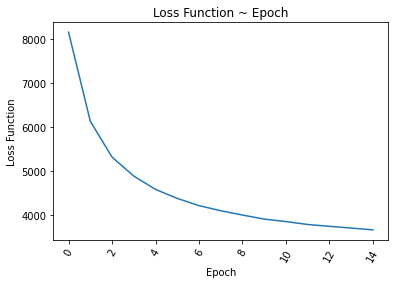

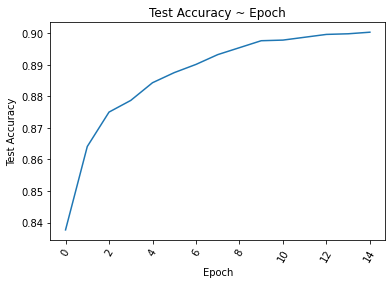

In [2]:
import numpy as np
import h5py
import time
import copy
import matplotlib.pyplot as plt

class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

args = {
    "num_epoches" : 15,
    "batch_size" : 128,
    "learning_rate" : 0.01,
    "learning_decay" : 0,
    "decay_factor" : 0.75,
    "momentum" : 0,
    "mu" : 0.9
}

config = Struct(**args)

def load_mnist(filename):
    """load MNIST data"""
    MNIST_data = h5py.File(filename, 'r')
    x_train = np.float32(MNIST_data['x_train'][:])
    y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
    x_test = np.float32(MNIST_data['x_test'][:])
    y_test = np.int32(np.array(MNIST_data['y_test'][:,0]))
    MNIST_data.close()
    return x_train,y_train,x_test,y_test

def initialize(num_inputs,num_classes):
    w = np.random.randn(num_classes, num_inputs) / np.sqrt(num_classes*num_inputs) # (10*784)
    b = np.random.randn(num_classes, 1) / np.sqrt(num_classes) # (10*1) 
    
    param = {
        'w' : w, # (10*784)
        'b' : b  # (10*1)
    }
    return param

def softmax(z):
    exp_list = np.exp(z)
    result = 1/sum(exp_list) * exp_list
    result = result.reshape((len(z),1))
    assert (result.shape == (len(z),1))
    return result

def mini_batch_gradient(param, x_batch, y_batch):
    batch_size = x_batch.shape[0]
    w_grad_list = []
    b_grad_list = []
    batch_loss = 0
    for i in range(batch_size):
        x,y = x_batch[i],y_batch[i]
        x = x.reshape((784,1)) # x: (784,1)
        E = np.zeros((10,1)) #(10*1)
        E[y][0] = 1 
        pred = softmax(np.matmul(param['w'], x)+param['b']) #(10*1)
        loss = -np.log(pred[int(y)])
        batch_loss += loss
        w_grad = E - pred
        w_grad = - np.matmul(w_grad, x.reshape((1,784)))
        w_grad_list.append(w_grad)

        b_grad = -(E - pred)
        b_grad_list.append(b_grad)

    dw = sum(w_grad_list)/batch_size
    db = sum(b_grad_list)/batch_size
    return dw, db, batch_loss

def eval(param, x_data, y_data):
    loss_list = []
    w = param['w'].transpose()
    dist = np.array([np.squeeze(softmax(np.matmul(x_data[i], w))) for i in range(len(y_data))])
    result = np.argmax(dist,axis=1)
    accuracy = sum(result == y_data)/float(len(y_data))
    loss_list = [-np.log(dist[i][int(y_data[i])]) for i in range(len(y_data))]
    loss = sum(loss_list)
    return loss, accuracy

def train(param, hyp , x_train, y_train, x_test, y_test):
    num_epoches = hyp.num_epoches
    batch_size = hyp.batch_size
    learning_rate = hyp.learning_rate
    mu = hyp.mu
    test_loss_list, test_accuracy_list = [],[]
    if bool(hyp.momentum) == True:
        W = np.zeros(param['w'].shape)
        b = np.zeros(param['b'].shape) 

    for epoch in range(num_epoches):
        rand_indices = np.random.choice(x_train.shape[0],x_train.shape[0],replace=False)
        num_batch = int(x_train.shape[0]/batch_size)
        batch_loss100 = 0
        if bool(hyp.learning_decay) == True:
            try:
                if test_accuracy_list[-1] - test_accuracy_list[-2] < 0.001:
                    learning_rate *= hyp.decay_factor
            except:
                pass
            s = 'learning rate: %.8f' % learning_rate

        for batch in range(num_batch):
            index = rand_indices[batch_size*batch:batch_size*(batch+1)]
            x_batch = x_train[index]
            y_batch = y_train[index]
            # calculate the gradient w.r.t w and b
            dw, db, batch_loss = mini_batch_gradient(param, x_batch, y_batch)
            batch_loss100 += batch_loss
            if bool(hyp.momentum) == True:
                W = mu * W + learning_rate * dw
                b = mu * b + learning_rate * db
                param['w'] -= W
                param['b'] -= b
            else:
                param['w'] -= learning_rate * dw
                param['b'] -= learning_rate * db
            if batch % 200 == 0:
                s = 'Epoch %d, Batch %d, Loss %.2f' % (epoch+1, batch, batch_loss)
                print(s)

                batch_loss100 = 0
        train_loss, train_accu = eval(param,x_train,y_train)
        test_loss, test_accu = eval(param,x_test,y_test)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accu)
        s = 'Epoch %d, Train Loss %.2f, Train Acc: %.4f, Test Loss %.2f, Test Acc: %.4f' % (epoch+1, train_loss, train_accu, test_loss, test_accu)
        print(s)
    return test_loss_list, test_accuracy_list

# loading MNIST data
x_train,y_train,x_test,y_test = load_mnist('data/MNISTdata.hdf5')

# setting the random seed
num_inputs = x_train.shape[1]
num_classes = len(set(y_train))
param = initialize(num_inputs,num_classes)

# train the model
loss_list, accuracy_list = train(param,config,x_train,y_train,x_test,y_test)
plt.plot(loss_list)
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.title('Loss Function ~ Epoch')
plt.show()
plt.plot(accuracy_list)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.title('Test Accuracy ~ Epoch')
plt.show()


## TensorFlow implement

Step: 100, loss: 1.510688, Acc: 0.828125
Step: 200, loss: 1.281642, Acc: 0.765625
Step: 300, loss: 0.982311, Acc: 0.835938
Step: 400, loss: 0.873657, Acc: 0.851562
Step: 500, loss: 0.759624, Acc: 0.851562
Step: 600, loss: 0.817731, Acc: 0.804688
Step: 700, loss: 0.747259, Acc: 0.804688
Step: 800, loss: 0.729712, Acc: 0.812500
Step: 900, loss: 0.580418, Acc: 0.851562
Step: 1000, loss: 0.761582, Acc: 0.820312
Step: 1100, loss: 0.505491, Acc: 0.882812
Step: 1200, loss: 0.543742, Acc: 0.882812
Step: 1300, loss: 0.536739, Acc: 0.867188
Step: 1400, loss: 0.463881, Acc: 0.921875
Step: 1500, loss: 0.504158, Acc: 0.898438
Step: 1600, loss: 0.489652, Acc: 0.867188
Step: 1700, loss: 0.572711, Acc: 0.835938
Step: 1800, loss: 0.475036, Acc: 0.875000
Step: 1900, loss: 0.445120, Acc: 0.875000
Step: 2000, loss: 0.525745, Acc: 0.875000
Test Accuracy: 0.885100


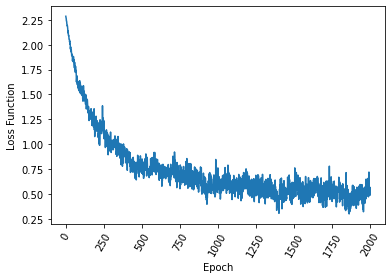

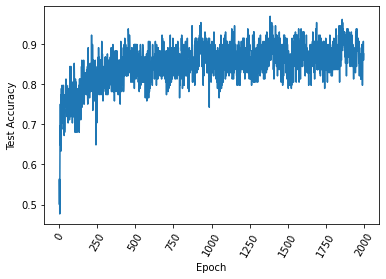

In [8]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
# parameters.
num_classes = 10 # 0 to 9 digits
num_feats = 784 # 28*28

# Training parameters.
learning_rate = 0.01
training_steps = 3000
batch_size = 128

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_feats]), x_test.reshape([-1, num_feats])
x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(1000).batch(batch_size).prefetch(1)


W = tf.Variable(tf.ones([num_feats, num_classes]), name="weight")
b = tf.Variable(tf.zeros([num_classes]), name="bias")

def logistic_regression(x):
    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred),1))

def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = cross_entropy(pred, y)
    gradients = g.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))

loss_list = []
acc_list = []
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)
    pred = logistic_regression(batch_x)
    loss = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)
    loss_list.append(loss)
    acc_list.append(acc)
    if step % 100 == 0:
        print("Step: %i, loss: %f, Acc: %f" % (step, loss, acc))
        
# Test model on validation set.
pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

plt.plot(loss_list)
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.show()
plt.plot(acc_list)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.show()

## Pytorch implement

Epoch [1/15], Step [200/600], Loss: 1.1493
Epoch [1/15], Step [400/600], Loss: 0.8776
Epoch [1/15], Step [600/600], Loss: 0.6825
Epoch [2/15], Step [200/600], Loss: 0.6959
Epoch [2/15], Step [400/600], Loss: 0.6640
Epoch [2/15], Step [600/600], Loss: 0.5526
Epoch [3/15], Step [200/600], Loss: 0.5564
Epoch [3/15], Step [400/600], Loss: 0.5302
Epoch [3/15], Step [600/600], Loss: 0.5053
Epoch [4/15], Step [200/600], Loss: 0.4286
Epoch [4/15], Step [400/600], Loss: 0.4429
Epoch [4/15], Step [600/600], Loss: 0.4583
Epoch [5/15], Step [200/600], Loss: 0.4640
Epoch [5/15], Step [400/600], Loss: 0.5315
Epoch [5/15], Step [600/600], Loss: 0.5566
Epoch [6/15], Step [200/600], Loss: 0.4040
Epoch [6/15], Step [400/600], Loss: 0.5293
Epoch [6/15], Step [600/600], Loss: 0.2704
Epoch [7/15], Step [200/600], Loss: 0.4705
Epoch [7/15], Step [400/600], Loss: 0.3997
Epoch [7/15], Step [600/600], Loss: 0.3653
Epoch [8/15], Step [200/600], Loss: 0.3742
Epoch [8/15], Step [400/600], Loss: 0.3348
Epoch [8/15

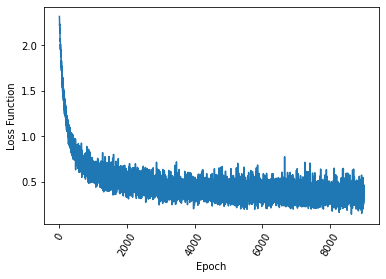

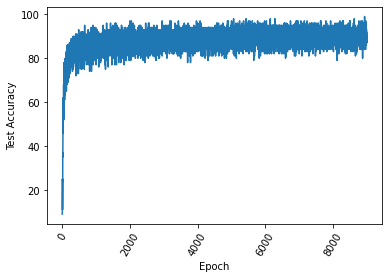

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# parameters 
input_size = 28 * 28    # 784
num_classes = 10
num_epochs = 15
batch_size = 100
learning_rate = 0.01

train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Logistic regression model
model = nn.Linear(input_size, num_classes)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Train the model
loss_list = []
acc_list = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss)
        _, predicted = torch.max(outputs.data, 1)
        acc = (predicted == labels).sum()
        acc_list.append(acc)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 200 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print(f'Accuracy of the model on the 10000 test images: {100 * (correct//total)}')
plt.plot(loss_list)
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.show()
plt.plot(acc_list)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.xticks(rotation=60)
plt.show()